In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
from statistics import mean

In [2]:
def moranDriftReference(N,maxOffCount,plot=False):
#     if N not in MDR:
    z = (N-1)/(2*N-1)
    gtr1 = lambda n: (N/(N-1))**2 * (z)**(n+1)
#         MDR[N] = [z if n==0 else gtr1(n) for n in range(maxOffCount+1)]
    if plot:
        return [z if n==0 else gtr1(n) for n in range(maxOffCount+1)]
    return [z if n==0 else gtr1(n) for n in range(max(N,maxOffCount)+1)] # MDR[N]

In [3]:
N = 3

TPM = []
for row in range(N+1):
    TPM.append([]) #add row-th row as an empty vector
    for col in range(N+1):
        #from row to column
        if col == row-1:
            #probability to loose one descendant count
            TPM[row].append((1-(row/N))*(row/N))
        elif col == row:
            #probability to stay at the same count
            TPM[row].append((row/N)**2 + (1-(row/N))**2)
        elif col == row+1:
            #probability to increase descendant count
            TPM[row].append((row/N)*(1-(row/N)))
        else:
            TPM[row].append(0.0)
# print(TPM)

In [4]:
TPM_MEMO = {}
def moranTPM(Ni,Nf):
    global TPM_MEMO
    key = (Ni,Nf)
#     print("MDKEY",key)
    if key not in TPM_MEMO:
        TPM = []
        if Ni == Nf:
#             print("same")
            for row in range(Ni+1):
                TPM.append([]) #add row-th row as an empty vector
                for col in range(Ni+1):
                    #from row to column
                    if col == row-1:
                        #probability to loose one descendant count
                        TPM[row].append((1-(row/Ni))*(row/Ni) if Ni>0 else 0.)
                    elif col == row:
                        #probability to stay at the same count
                        TPM[row].append((row/Ni)**2 + (1-(row/Ni))**2 if Ni>0 else 1.)
                    elif col == row+1:
                        #probability to increase descendant count
                        TPM[row].append((row/Ni)*(1-(row/Ni)) if Ni>0 else 0.)
                    else:
                        TPM[row].append(0.0)
        elif Ni+1 == Nf:
#             print("inc")
            for row in range(Ni+1):
                TPM.append([]) #add row-th row as an empty vector
                for col in range(Nf+1):
                    #from row to column
                    if col == row:
                        #probability to stay at the same count
                        TPM[row].append(1-(row/Ni) if Ni>0 else 1.)
                    elif col == row+1:
                        #probability to increase descendant count
                        TPM[row].append(row/Ni if Ni>0 else 0.)
                    else:
                        TPM[row].append(0.0)
        elif Ni-1 == Nf:
#             print("dec")
            for row in range(Ni+1):
                TPM.append([]) #add row-th row as an empty vector
                for col in range(Nf+1):
                    #from row to column
                    if col == row-1:
                        #probability to loose one descendant count
                        TPM[row].append(row/Ni if Ni>0 else 0.)
                    elif col == row:
                        #probability to stay at the same count
                        TPM[row].append(1-(row/Ni) if Ni>0 else 1.)
                    else:
                        TPM[row].append(0.0)
        else:
            print("ERROR: Invalid population sizes in moran drift reference.")
            return None
        TPM_MEMO[key] = np.array(TPM)
#         print(key)
#         print(np.array(TPM))
        
    else:
        TPM = TPM_MEMO[key]
         
    return TPM

def moranDriftReference2(popSizeHistory):
    Xnp = np.array([0.,1.]+[0. for _ in range(popSizeHistory[0]-1)])
    for Ni,Nf in zip(popSizeHistory[:-1],popSizeHistory[1:]):
        TPMnp = np.array(moranTPM(Ni,Nf))
        Xnp = np.dot(Xnp,TPMnp)
    return Xnp

print(moranDriftReference2([3,2,3,2,3,2,3,2]))

[0.56790123 0.19753086 0.2345679 ]


[[1.         0.         0.         0.        ]
 [0.22222222 0.55555556 0.22222222 0.        ]
 [0.         0.22222222 0.55555556 0.22222222]
 [0.         0.         0.         1.        ]]
[0. 1. 0. 0.]
[0.22222222 0.55555556 0.22222222 0.        ]
[0.34567901 0.35802469 0.24691358 0.04938272]
[0.42524005 0.25377229 0.21673525 0.1042524 ]


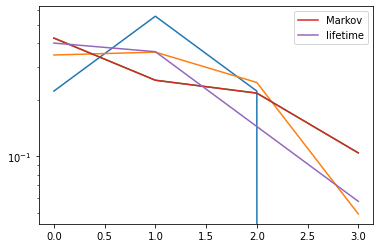

In [5]:

TPMnp = np.array(TPM)

Xnp = np.array([0.,1.]+[0. for _ in range(N-1)])

print(TPMnp)
print(Xnp)

for _ in range(N):
    Xnp = np.dot(Xnp,TPMnp)
    print(Xnp)
    plt.plot(Xnp)



plt.plot(Xnp,label="Markov")
plt.plot(moranDriftReference(N,0),label="lifetime")
plt.yscale("log")
plt.legend()
plt.show()

## ALGEBRA TEST
# TPMnp = np.array(TPM)
# Xnp = np.array([0.,1.]+[0. for _ in range(N-1)])
# print(TPMnp)
# print(Xnp)
# for _ in range(N):
#     TPMnp = np.dot(TPMnp,TPMnp)
#     print(TPMnp)
#     plt.plot(Xnp)
# Xnp = np.dot(Xnp,TPMnp)
# plt.plot(Xnp,label="Markov")
# plt.plot(moranDriftReference(N,0),label="lifetime")
# plt.yscale("log")
# plt.legend()
# plt.show()

In [6]:
observedLog = []
for replicate in range(5000):
    population = [i for i in range(N)]

    for generation in range(N):
        birthID = random.randint(0,N-1)
        deathID = random.randint(0,N-1)
        population[deathID] = population[birthID]

    ancesterIDCounts = Counter(population)
    descendentCounts = Counter(ancesterIDCounts.values())
    descendentCounts[0] = N-sum(descendentCounts.values())
    Observed = [descendentCounts[x]/N if x in descendentCounts else 0 
                for x in range(max(N,max(descendentCounts.keys()))+1)]
    observedLog.append(Observed)
    
#group entrys by descendantCount instead of replicate
stuff = zip(*observedLog)
finalData = [mean(thing) for thing in stuff]

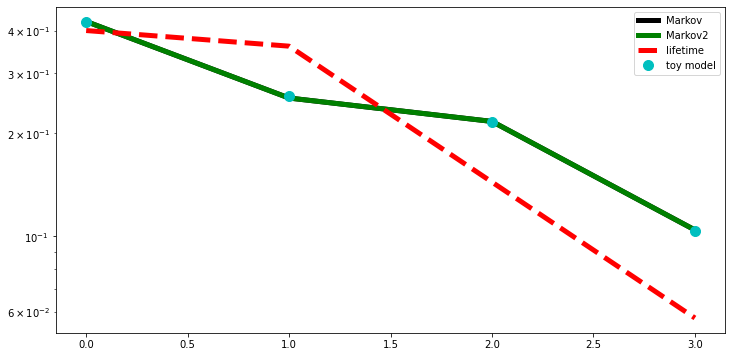

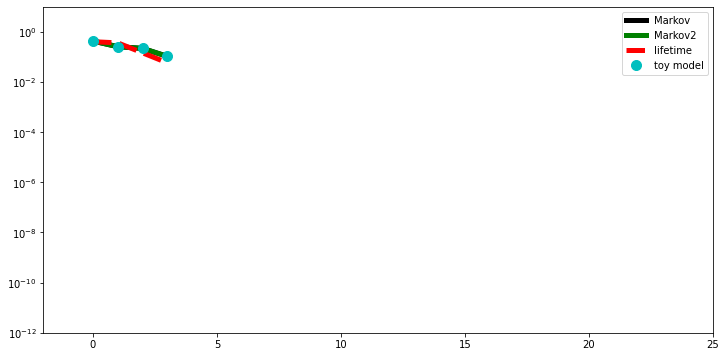

In [14]:
plt.figure(figsize=(12,6))
plt.plot(Xnp,label="Markov",linewidth=5,color="k")
plt.plot(moranDriftReference2([N for _ in range(N+1)]),label="Markov2",linewidth=5,color="g")
plt.plot(moranDriftReference(N,0),label="lifetime",linewidth=5,linestyle="--",color="r")
plt.plot(finalData,marker="o",color="c",markersize="10",linestyle="",label="toy model")
plt.yscale("log")
plt.legend()
plt.show()

#ZOOM OF ABOVE
plt.figure(figsize=(12,6))
plt.plot(Xnp,label="Markov",linewidth=5,color="k")
plt.plot(moranDriftReference2([N for _ in range(N+1)]),label="Markov2",linewidth=5,color="g")
plt.plot(moranDriftReference(N,0),label="lifetime",linewidth=5,linestyle="--",color="r")
plt.plot(finalData,marker="o",color="c",markersize="10",linestyle="",label="toy model")
plt.yscale("log")
plt.legend()
###
plt.xlim(-2,25)
plt.ylim(10**-12,10)
###
plt.show()